In [1]:
import re
import os
import platform
import sys

# flag if notebook is running on Gradescope
if re.search(r'amzn', platform.uname().release):
    GS = True
else:
    GS = False

# flag if notebook is running on Colaboratory
try:
  import google.colab
  COLAB = True
except:
  COLAB = False

# flag if running on Linux lab machines.
cname = platform.uname().node
if re.search(r'(guardian|colossus|c28)', cname):
    LLM = True
else:
    LLM = False

print("System: GS - %s, COLAB - %s, LLM - %s" % (GS, COLAB, LLM))

# Import standard DS packages
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

System: GS - False, COLAB - False, LLM - True


# 1. Load the Liver Study Dataset

In [2]:
# Connect to Google Drive
# Comment out in linux Environment
# from google.colab import drive
# drive.mount('/content/drive')

In [3]:
liverDF = pd.read_csv(filepath_or_buffer='Indian Liver Patient Dataset (ILPD).csv',
                     header=0)

print(liverDF.head())

   Age  Gender    TB   DB  Alkphos  Sgpt  Sgot   TP  ALB  A/G Ratio  Selector
0   65  Female   0.7  0.1      187    16    18  6.8  3.3       0.90         1
1   62    Male  10.9  5.5      699    64   100  7.5  3.2       0.74         1
2   62    Male   7.3  4.1      490    60    68  7.0  3.3       0.89         1
3   58    Male   1.0  0.4      182    14    20  6.8  3.4       1.00         1
4   72    Male   3.9  2.0      195    27    59  7.3  2.4       0.40         1


# 2. Conduct Exploratory Analysis

In [4]:
# number of rows, number of columns
liverDF.shape

(583, 11)

In [5]:
# the data type of each attribute (column)
liverDF.dtypes

Age            int64
Gender        object
TB           float64
DB           float64
Alkphos        int64
Sgpt           int64
Sgot           int64
TP           float64
ALB          float64
A/G Ratio    float64
Selector       int64
dtype: object

In [6]:
# Initial Summary Statistics
liverDF.describe()

,Age,TB,DB,Alkphos,Sgpt,Sgot,TP,ALB,A/G Ratio,Selector
count,583.000000,583.000000,583.000000,583.000000,583.000000,583.000000,583.000000,583.000000,579.000000,583.000000
mean,44.746141,3.298799,1.486106,290.576329,80.713551,109.910806,6.483190,3.141852,0.947064,1.286449
std,16.189833,6.209522,2.808498,242.937989,182.620356,288.918529,1.085451,0.795519,0.319592,0.452490
min,4.000000,0.400000,0.100000,63.000000,10.000000,10.000000,2.700000,0.900000,0.300000,1.000000
25%,33.000000,0.800000,0.200000,175.500000,23.000000,25.000000,5.800000,2.600000,0.700000,1.000000
50%,45.000000,1.000000,0.300000,208.000000,35.000000,42.000000,6.600000,3.100000,0.930000,1.000000
75%,58.000000,2.600000,1.300000,298.000000,60.500000,87.000000,7.200000,3.800000,1.100000,2.000000
max,90.000000,75.000000,19.700000,2110.000000,2000.000000,4929.000000,9.600000,5.500000,2.800000,2.000000


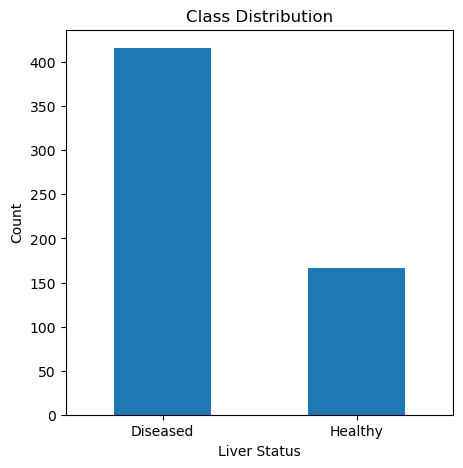

In [7]:
# Observe a potential imbalance between possible selectors
plt.figure(figsize=(5, 5))
ax = liverDF['Selector'].value_counts().plot(kind='bar',
                                             figsize=(5, 5),
                                             title="Class Distribution")

plt.xticks((0, 1), ('Diseased','Healthy'), rotation='horizontal')
ax.set_xlabel('Liver Status')
ax.set_ylabel('Count')

plt.show()

<Axes: >

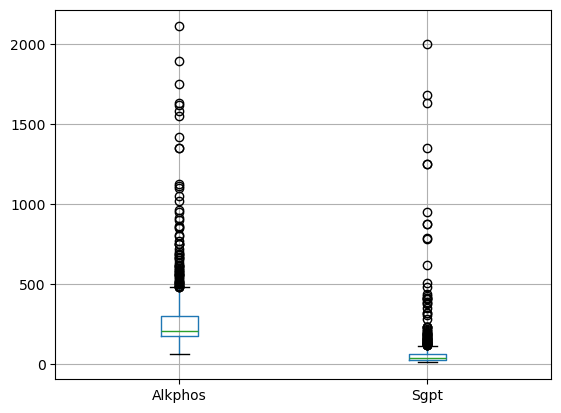

In [8]:
# Visualize the range and spread of the data fields using box plots
liverDF.boxplot(column=['Alkphos','Sgpt'])

<Axes: >

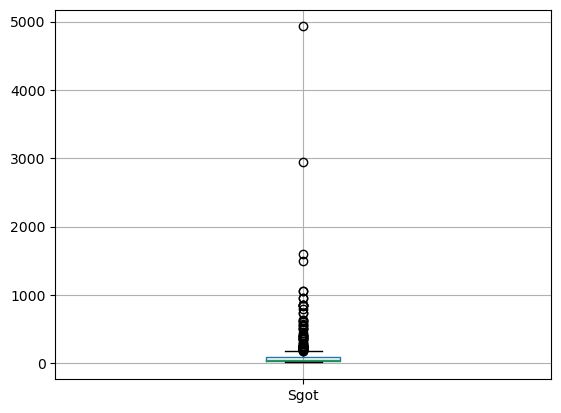

In [9]:
liverDF.boxplot(column=['Sgot'])

<Axes: >

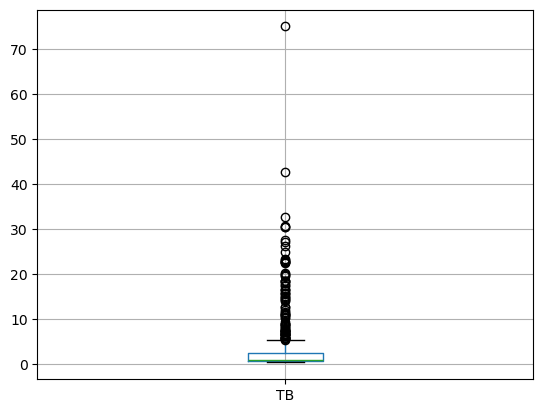

In [10]:
liverDF.boxplot(column=['TB'])

<Axes: >

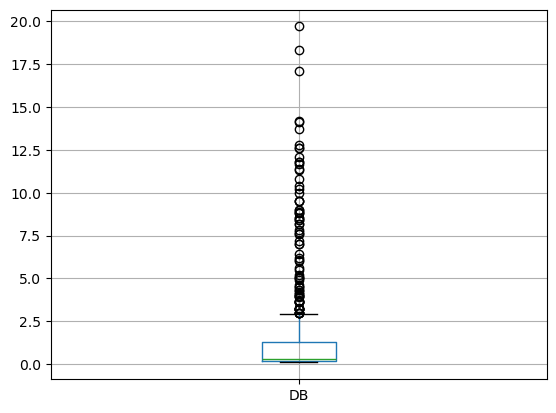

In [11]:
liverDF.boxplot(column=['DB'])

<Axes: >

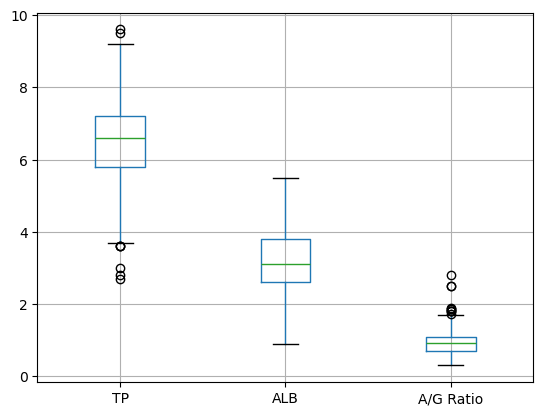

In [12]:
liverDF.boxplot(column=['TP','ALB','A/G Ratio'])

<Axes: >

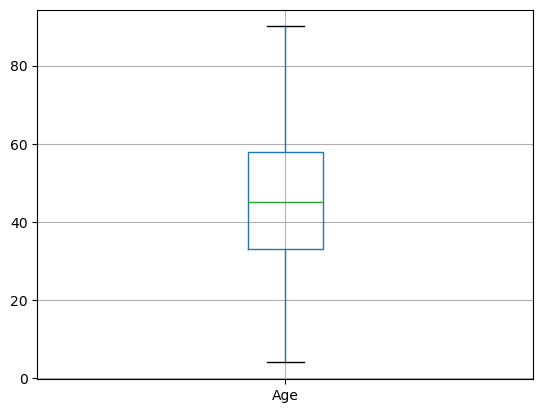

In [13]:
liverDF.boxplot(column=['Age'])

In [14]:
from scipy.stats.mstats import winsorize

print(liverDF[(liverDF['Sgpt']>=2000) | (liverDF['Sgot']>=2000) | (liverDF['Alkphos']>=1000)])
print(liverDF.isna().sum())

# Save all rows for further testing
liverDFAll = liverDF

# Preprocessing technique #1, Drop rows with extreme outliers
# liverDF.drop(liverDF[(liverDF['Sgpt']>=2000) | (liverDF['Sgot']>=2000) | (liverDF['Alkphos']>=1000)].index, inplace=True)
# Winsorize to move the outliers closer to the 1-3 IQR
winsorize(liverDF['Alkphos'], limits=(0, 0.075), inplace = True)
winsorize(liverDF['Sgpt'], limits=(0, 0.075), inplace = True)
winsorize(liverDF['Sgot'], limits=(0, 0.075), inplace = True)
winsorize(liverDF['TB'], limits=(0, 0.075), inplace = True)
winsorize(liverDF['DB'], limits=(0, 0.075), inplace = True)

# Preprocessing technique #2, Drop NaN
#liverDF.dropna(subset=['A/G Ratio'], inplace=True)
# or use an imputation to fill with median values based on like values by Selector
# liverDF['A/G Ratio'].fillna(liverDF.groupby('Selector')['A/G Ratio'].transform('median'), inplace=True)
liverDF['A/G Ratio'].fillna(liverDF.groupby('Selector')['A/G Ratio'].transform('mean'), inplace=True)

# Fill NaN Values with median because of strong outliers
# Commented out section, current data does not have NaN values in these fields
'''liverDFScaled = liverDFScaled.fillna(liverDFScaled['TB'].median())
liverDFScaled = liverDFScaled.fillna(liverDFScaled['DB'].median())
liverDFScaled = liverDFScaled.fillna(liverDFScaled['Alkphos'].median())
liverDFScaled = liverDFScaled.fillna(liverDFScaled['Sgpt'].median())
liverDFScaled = liverDFScaled.fillna(liverDFScaled['TP'].median())
liverDFScaled = liverDFScaled.fillna(liverDFScaled['ALB'].median())
liverDFScaled = liverDFScaled.fillna(liverDFScaled['A/G Ratio'].median())'''

# number of rows, number of columns
print(liverDF.shape)
# Updated Summary Statistics
liverDF.describe()

     Age  Gender    TB    DB  Alkphos  Sgpt  Sgot   TP  ALB  A/G Ratio  \
77    68  Female   0.6   0.1     1620    95   127  4.6  2.1       0.80   
115   50    Male   7.3   3.6     1580    88    64  5.6  2.3       0.60   
116   48    Male   0.7   0.1     1630    74   149  5.3  2.0       0.60   
117   32    Male  12.7   6.2      194  2000  2946  5.7  3.3       1.30   
128   58  Female   1.7   0.8     1896    61    83  8.0  3.9       0.95   
135   66    Male  11.3   5.6     1110  1250  4929  7.0  2.4       0.50   
161   60    Male  11.5   5.0     1050    99   187  6.2  2.8       0.80   
177   75    Male  14.8   9.0     1020    71    42  5.3  2.2       0.70   
195   60    Male   2.4   1.0     1124    30    54  5.2  1.9       0.50   
199    7  Female  27.2  11.8     1420   790  1050  6.1  2.0       0.40   
233   33    Male   2.0   1.4     2110    48    89  6.2  3.0       0.90   
419   55  Female   8.2   3.9     1350    52    65  6.7  2.9       0.70   
420   55  Female  10.9   5.1     1350 

,Age,TB,DB,Alkphos,Sgpt,Sgot,TP,ALB,A/G Ratio,Selector
count,583.000000,583.000000,583.000000,583.000000,583.000000,583.000000,583.000000,583.000000,583.000000,583.000000
mean,44.746141,2.536707,1.173242,261.531732,53.777015,71.236707,6.483190,3.141852,0.947234,1.286449
std,16.189833,3.133067,1.709827,132.971467,47.049419,68.765643,1.085451,0.795519,0.318534,0.452490
min,4.000000,0.400000,0.100000,63.000000,10.000000,10.000000,2.700000,0.900000,0.300000,1.000000
25%,33.000000,0.800000,0.200000,175.500000,23.000000,25.000000,5.800000,2.600000,0.700000,1.000000
50%,45.000000,1.000000,0.300000,208.000000,35.000000,42.000000,6.600000,3.100000,0.930000,1.000000
75%,58.000000,2.600000,1.300000,298.000000,60.500000,87.000000,7.200000,3.800000,1.100000,2.000000
max,90.000000,11.300000,6.000000,592.000000,178.000000,248.000000,9.600000,5.500000,2.800000,2.000000


## 2.1 Due to extreme variability across fields, scale the numerical attributes.

In [15]:
# Preprocessing technique #3, Scale the data
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

scaler = StandardScaler()
#scaler = MinMaxScaler()

liverDFScaled = liverDF

scaledColumns = ['TB','DB','Alkphos','Sgpt','Sgot','TP','ALB','A/G Ratio']
liverDFScaled[scaledColumns] = scaler.fit_transform(liverDFScaled[scaledColumns])

liverDFScaled.head()

,Age,Gender,TB,DB,Alkphos,Sgpt,Sgot,TP,ALB,A/G Ratio,Selector
0,65,Female,-0.586736,-0.628229,-0.560991,-0.803612,-0.774841,0.292120,0.198969,-0.148413,1
1,62,Male,2.671656,2.532696,2.487391,0.217468,0.418639,0.937566,0.073157,-0.651145,1
2,62,Male,1.521635,1.713197,1.719651,0.132378,-0.047109,0.476533,0.198969,-0.179834,1
3,58,Male,-0.490901,-0.452622,-0.598625,-0.846157,-0.745731,0.292120,0.324781,0.165794,1
4,72,Male,0.435504,0.483948,-0.500776,-0.569614,-0.178101,0.753153,-0.933340,-1.719450,1


### 2.2.1 Replot the data and distributions.

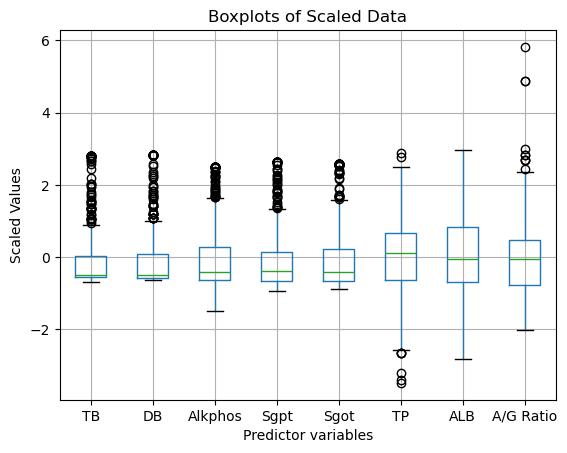

"weighted_scaler = 10\n# Increase range for heavily weighted features\nliverDFScaled['ALB'] = liverDFScaled['ALB'] * weighted_scaler\nliverDFScaled['A/G Ratio'] = liverDFScaled['A/G Ratio'] * weighted_scaler\n\n# Reduce range for lesser weighted features\nliverDFScaled['Alkphos'] = liverDFScaled['Alkphos'] / weighted_scaler\nliverDFScaled['Sgpt'] = liverDFScaled['Sgpt'] / weighted_scaler\nliverDFScaled['Sgot'] = liverDFScaled['Sgot'] / weighted_scaler"

In [16]:
# Note that with the data fields scaled it's easier to make observations from a single chart
# More exploration is required for TB, DB, Alkphos, Sgpt, and Sgot due to extreme skewness
#plt.figure(figsize=(8, 6))
ax = liverDFScaled.boxplot(scaledColumns)
ax.set_title('Boxplots of Scaled Data')
ax.set_xlabel('Predictor variables')
ax.set_ylabel('Scaled Values')
#ax.grid(False)

plt.show()

# Testing to rescale fields of greater importance according to medical documentation
# Provided little impact to training and testing - commented out for exploration
# in future work.
'''weighted_scaler = 10
# Increase range for heavily weighted features
liverDFScaled['ALB'] = liverDFScaled['ALB'] * weighted_scaler
liverDFScaled['A/G Ratio'] = liverDFScaled['A/G Ratio'] * weighted_scaler

# Reduce range for lesser weighted features
liverDFScaled['Alkphos'] = liverDFScaled['Alkphos'] / weighted_scaler
liverDFScaled['Sgpt'] = liverDFScaled['Sgpt'] / weighted_scaler
liverDFScaled['Sgot'] = liverDFScaled['Sgot'] / weighted_scaler'''

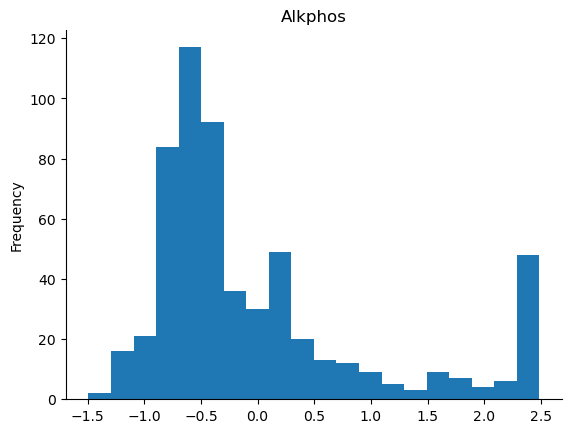

In [17]:
# Observe the distribution of fields with a large range and outliers
liverDFScaled['Alkphos'].plot(kind='hist', bins=20, title='Alkphos')
plt.gca().spines[['top', 'right',]].set_visible(False)

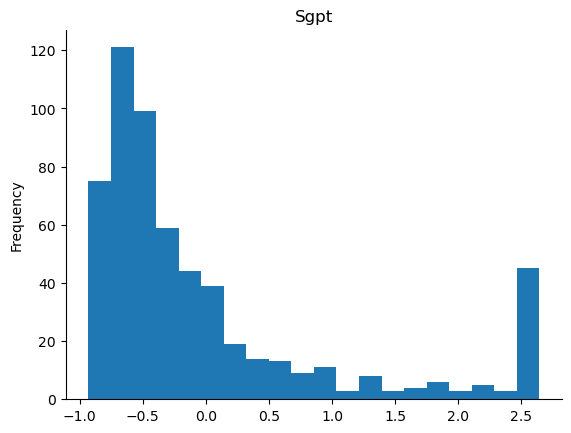

In [18]:
# Observe the distribution of fields with a large range and outliers
liverDFScaled['Sgpt'].plot(kind='hist', bins=20, title='Sgpt')
plt.gca().spines[['top', 'right',]].set_visible(False)

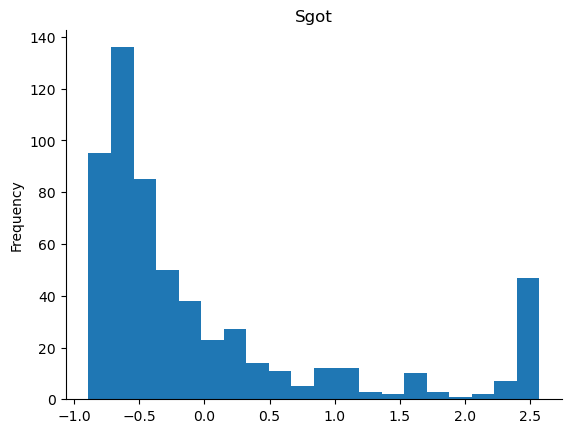

In [19]:
# Observe the distribution of fields with a large range and outliers
liverDFScaled['Sgot'].plot(kind='hist', bins=20, title='Sgot')
plt.gca().spines[['top', 'right',]].set_visible(False)

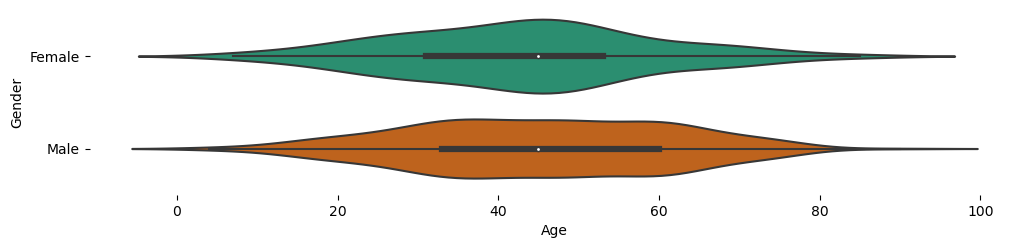

In [20]:
# Observe the relationships between various fields: Gender vs Age
figsize = (12, 1.2 * len(liverDFScaled['Gender'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(liverDFScaled, x='Age', y='Gender', inner='box', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

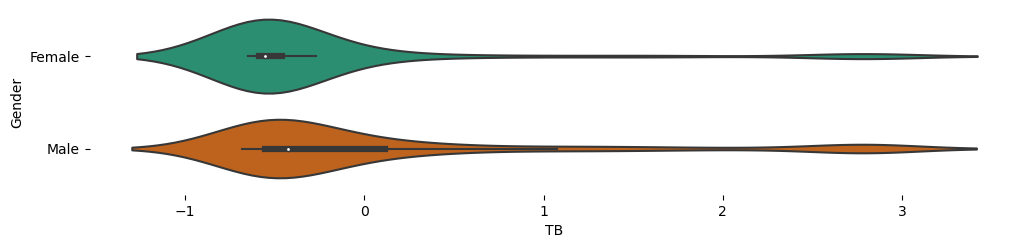

In [21]:
# Gender vs TB
figsize = (12, 1.2 * len(liverDFScaled['Gender'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(liverDFScaled, x='TB', y='Gender', inner='box', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

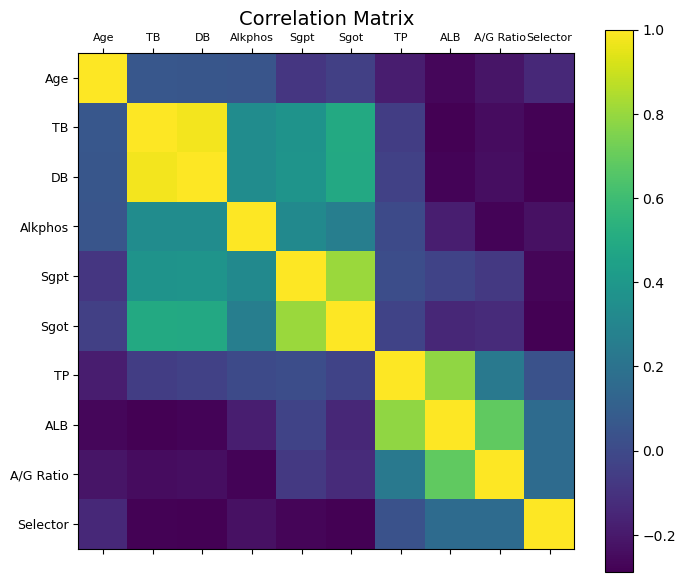

In [22]:
# Plot correlation matrix to observe potential correlation between numeric fields
Columns = ['Age','TB','DB','Alkphos','Sgpt','Sgot','TP','ALB','A/G Ratio','Selector']
f = plt.figure(figsize=(8, 7))
plt.matshow(liverDFScaled[Columns].corr(), fignum=f.number)
plt.xticks(range(len(Columns)), Columns, fontsize=8)
plt.yticks(range(len(Columns)), Columns, fontsize=9)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=10)
plt.title('Correlation Matrix', fontsize=14);

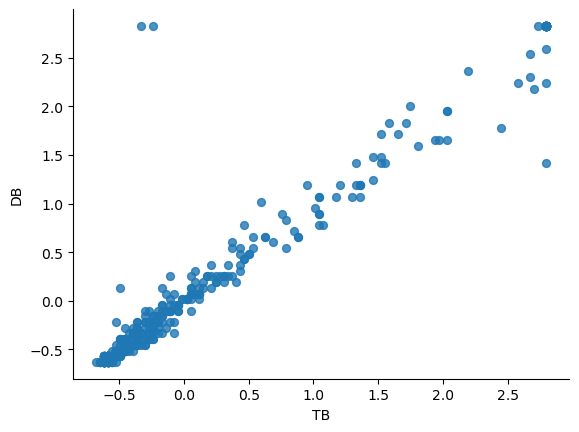

In [23]:
# Observing potential correlation between specific fields: TB vs DB
liverDFScaled.plot(kind='scatter', x='TB', y='DB', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

### 2.2.2 Final Pre-processing, mapping Gender and Selector to binary values, 0 and 1.

In [24]:
import matplotlib.pyplot as plt
from sklearn import neighbors
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.linear_model import LogisticRegression

# Final Pre-Processing Steps prior to testing the models
# Convert Gender to binary values
liverDFScaled['Gender'].replace('Male', 0, inplace = True)
liverDFScaled['Gender'].replace('Female', 1, inplace = True)

# Re-map Selector: Unhealthy = 1; Healthy = 2, convert to 0 and 1 respectively
liverDFScaled['Selector'] = liverDFScaled['Selector'].map({1:0,2:1})

# Column List ['Age', 'Gender', 'TB','DB','Alkphos','Sgpt','Sgot','TP','ALB','A/G Ratio']
# Ingore the following fields: Age, Gender, TB, and A/G Ratio
# Future runs will incorporate testing only male or female records to check bias
X_Columns = ['TB','Alkphos','Sgpt','Sgot','TP','ALB']

# 3. Generate the Model

### 3.1.1 Training the Model.

KNN Model Results, K= 20
Accuracy = 0.7008547008547008
Recall = 0.17647058823529413
Precision = 0.46153846153846156

Logistic Regression Model Results, C= 0.0001
Accuracy = 0.7094017094017094
Recall = 0.0
Precision = 0.0



/home/campus05/psweiss/.conda/envs/cs5831/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


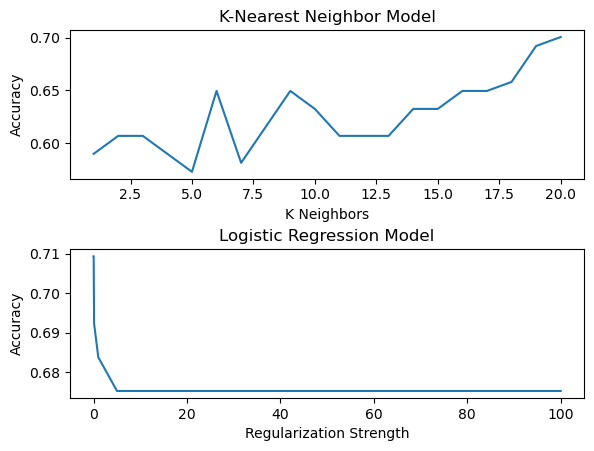

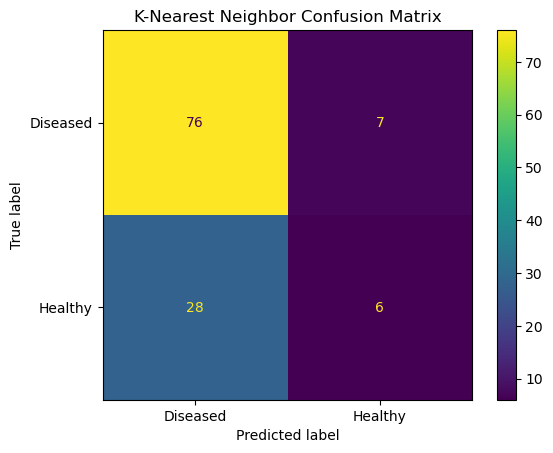

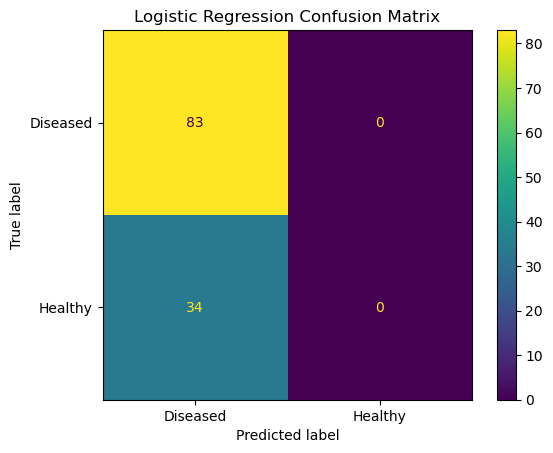

In [25]:
# Split Features and Targets
liverDFScaled_X = liverDFScaled[X_Columns]
liverDFScaled_y = liverDFScaled['Selector']

# Split Data
train_X, test_X, train_y, test_y = train_test_split(liverDFScaled_X,
      liverDFScaled_y, test_size = .2, shuffle = True,
      stratify = liverDFScaled_y, random_state = 42)

# Create Graph for Accuracy
fig, (ax1, ax2) = plt.subplots(2, 1)
fig.tight_layout(pad = 3)

# K-Nearest Neighbor
k_range = range(1, 21)
acc = []
maxKnnAcc = 0
bestKnn = 0

for k in k_range:
  knn = KNeighborsClassifier(n_neighbors = k)
  knn.fit(train_X, train_y)
  yhat = knn.predict(test_X)
  accuracy = accuracy_score(test_y, yhat)
  # Retain the best found accuracy and related nearest neighbor value
  if accuracy > maxKnnAcc :
    maxKnnAcc = accuracy
    bestKnn = k
  acc.append(accuracy)

# Put KNN Accuracy in Axes
ax1.plot(k_range, acc)
ax1.set(xlabel = 'K Neighbors', ylabel = 'Accuracy')
ax1.set_title('K-Nearest Neighbor Model')

# KNN Confusion Matrix
knn_con = KNeighborsClassifier(n_neighbors = bestKnn)
knn_con.fit(train_X, train_y)
yhat = knn_con.predict(test_X)
conf_mat = confusion_matrix(test_y, yhat)
conf_knn_disp = ConfusionMatrixDisplay(conf_mat, display_labels = ['Diseased', 'Healthy'])
conf_knn_disp.plot()
conf_knn_disp.ax_.set_title('K-Nearest Neighbor Confusion Matrix')

# Print Primary Scores of Consideration
print('KNN Model Results, K=',bestKnn)
print(f"Accuracy = {accuracy_score(test_y, yhat)}")
print(f"Recall = {recall_score(test_y, yhat)}")
print(f"Precision = {precision_score(test_y, yhat)}")
print('')

# Logistic Regression
c_range = [.0001, .001, .01, .1, 1, 5, 10, 20, 50, 100]
acc = []
maxLogAcc = 0
bestC = 0

for c in c_range:
  lg = LogisticRegression(C = c)
  lg.fit(train_X, train_y)
  yhat = lg.predict(test_X)
  accuracy = accuracy_score(test_y, yhat)
  # Retain the best found accuracy and related C value
  if accuracy > maxLogAcc :
    maxLogAcc = accuracy
    bestC = c
  acc.append(accuracy)

# Put LG Accuracy in Axes
ax2.plot(c_range, acc)
ax2.set(xlabel = 'Regularization Strength', ylabel = 'Accuracy')
ax2.set_title('Logistic Regression Model')

# Log. Regression Confusion Matrix
lg = LogisticRegression(C = bestC)
lg.fit(train_X, train_y)
yhat = lg.predict(test_X)
conf_mat = confusion_matrix(test_y, yhat)
conf_lg_disp = ConfusionMatrixDisplay(conf_mat, display_labels = ['Diseased', 'Healthy'])
conf_lg_disp.plot()
conf_lg_disp.ax_.set_title('Logistic Regression Confusion Matrix')

# Print Primary Scores of Consideration
print('Logistic Regression Model Results, C=', bestC)
print(f"Accuracy = {accuracy_score(test_y, yhat)}")
print(f"Recall = {recall_score(test_y, yhat)}")
print(f"Precision = {precision_score(test_y, yhat)}")
print('')

# Plot Model Results
plt.show()

# 4. Test for Gender Bias

KNN Model Results, K= 3
Accuracy = 0.7640449438202247
Recall = 0.4583333333333333
Precision = 0.5789473684210527

Logistic Regression Model Results, C= 0.0001
Accuracy = 0.7303370786516854
Recall = 0.0
Precision = 0.0



/home/campus05/psweiss/.conda/envs/cs5831/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


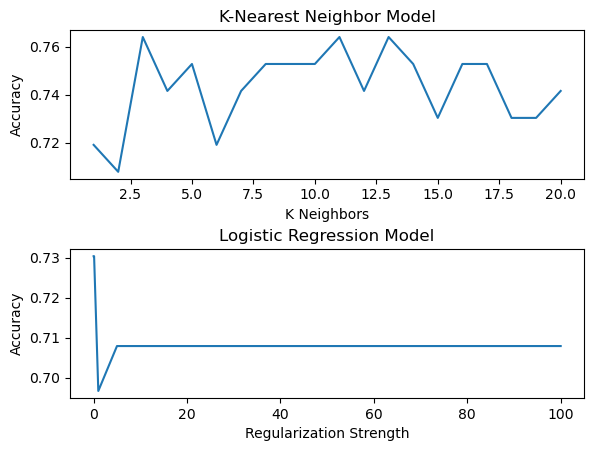

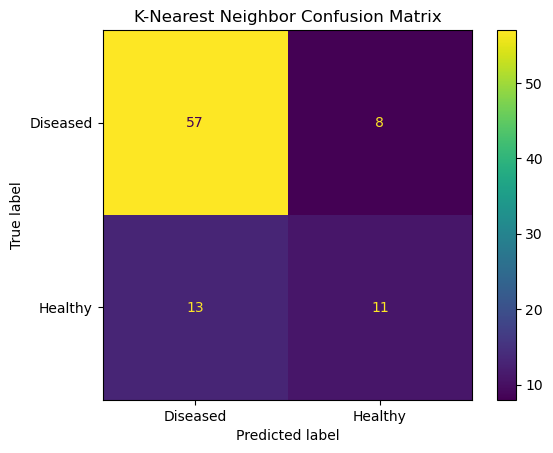

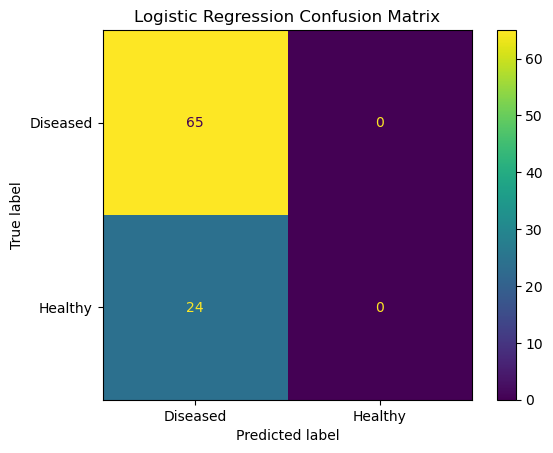

In [26]:
# Split Features and Targets
# Column List ['Age', 'Gender', 'TB','DB','Alkphos','Sgpt','Sgot','TP','ALB','A/G Ratio']
# Ingore the following fields: Age, Gender, TB, and A/G Ratio
# Future runs will incorporate testing only male or female records to check bias
liverDFScaledMale_X = liverDFScaled[X_Columns].loc[liverDFScaled['Gender'] == 0]
liverDFScaledMale_y = liverDFScaled['Selector'].loc[liverDFScaled['Gender'] == 0]

# Split Data
train_X, test_X, train_y, test_y = train_test_split(liverDFScaledMale_X,
      liverDFScaledMale_y, test_size = .2, shuffle = True,
      stratify = liverDFScaledMale_y, random_state = 42)

# Create Graph for Accuracy
fig, (ax1, ax2) = plt.subplots(2, 1)
fig.tight_layout(pad = 3)

# K-Nearest Neighbor
k_range = range(1, 21)
acc = []
maxKnnAcc = 0
bestKnn = 0

for k in k_range:
  knn = KNeighborsClassifier(n_neighbors = k)
  knn.fit(train_X, train_y)
  yhat = knn.predict(test_X)
  accuracy = accuracy_score(test_y, yhat)
  # Retain the best found accuracy and related nearest neighbor value
  if accuracy > maxKnnAcc :
    maxKnnAcc = accuracy
    bestKnn = k
  acc.append(accuracy)

# Put KNN Accuracy in Axes
ax1.plot(k_range, acc)
ax1.set(xlabel = 'K Neighbors', ylabel = 'Accuracy')
ax1.set_title('K-Nearest Neighbor Model')

# KNN Confusion Matrix
knn_con = KNeighborsClassifier(n_neighbors = bestKnn)
knn_con.fit(train_X, train_y)
yhat = knn_con.predict(test_X)
conf_mat = confusion_matrix(test_y, yhat)
conf_knn_disp = ConfusionMatrixDisplay(conf_mat, display_labels = ['Diseased', 'Healthy'])
conf_knn_disp.plot()
conf_knn_disp.ax_.set_title('K-Nearest Neighbor Confusion Matrix')

# Print Primary Scores of Consideration
print('KNN Model Results, K=',bestKnn)
print(f"Accuracy = {accuracy_score(test_y, yhat)}")
print(f"Recall = {recall_score(test_y, yhat)}")
print(f"Precision = {precision_score(test_y, yhat)}")
print('')

# Logistic Regression
c_range = [.0001, .001, .01, .1, 1, 5, 10, 20, 50, 100]
acc = []
maxLogAcc = 0
bestC = 0

for c in c_range:
  lg = LogisticRegression(C = c)
  lg.fit(train_X, train_y)
  yhat = lg.predict(test_X)
  accuracy = accuracy_score(test_y, yhat)
  # Retain the best found accuracy and related C value
  if accuracy > maxLogAcc :
    maxLogAcc = accuracy
    bestC = c
  acc.append(accuracy)

# Put LG Accuracy in Axes
ax2.plot(c_range, acc)
ax2.set(xlabel = 'Regularization Strength', ylabel = 'Accuracy')
ax2.set_title('Logistic Regression Model')

# Log. Regression Confusion Matrix
lg = LogisticRegression(C = bestC)
lg.fit(train_X, train_y)
yhat = lg.predict(test_X)
conf_mat = confusion_matrix(test_y, yhat)
conf_lg_disp = ConfusionMatrixDisplay(conf_mat, display_labels = ['Diseased', 'Healthy'])
conf_lg_disp.plot()
conf_lg_disp.ax_.set_title('Logistic Regression Confusion Matrix')

# Print Primary Scores of Consideration
print('Logistic Regression Model Results, C=', bestC)
print(f"Accuracy = {accuracy_score(test_y, yhat)}")
print(f"Recall = {recall_score(test_y, yhat)}")
print(f"Precision = {precision_score(test_y, yhat)}")
print('')

# Plot Model Results
plt.show()


KNN Model Results, K= 4
Accuracy = 0.5517241379310345
Recall = 0.1
Precision = 0.2

Logistic Regression Model Results, C= 0.0001
Accuracy = 0.6551724137931034
Recall = 0.0
Precision = 0.0



/home/campus05/psweiss/.conda/envs/cs5831/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


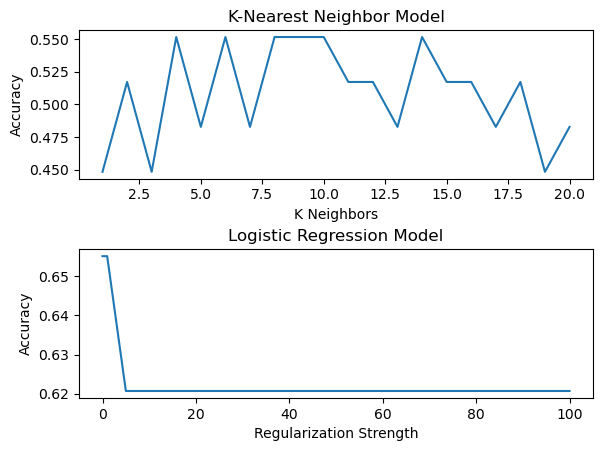

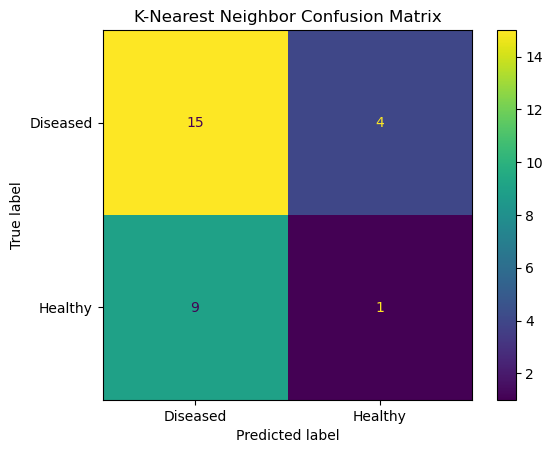

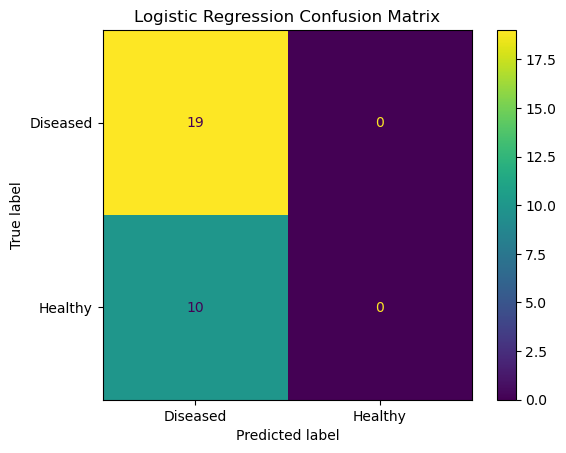

In [27]:
# Split Features and Targets
# Column List ['Age', 'Gender', 'TB','DB','Alkphos','Sgpt','Sgot','TP','ALB','A/G Ratio']
# Ingore the following fields: Age, Gender, TB, and A/G Ratio
# Future runs will incorporate testing only male or female records to check bias
liverDFScaledMale_X = liverDFScaled[X_Columns].loc[liverDFScaled['Gender'] == 1]
liverDFScaledMale_y = liverDFScaled['Selector'].loc[liverDFScaled['Gender'] == 1]

# Split Data
train_X, test_X, train_y, test_y = train_test_split(liverDFScaledMale_X,
      liverDFScaledMale_y, test_size = .2, shuffle = True,
      stratify = liverDFScaledMale_y, random_state = 42)

# Create Graph for Accuracy
fig, (ax1, ax2) = plt.subplots(2, 1)
fig.tight_layout(pad = 3)

# K-Nearest Neighbor
k_range = range(1, 21)
acc = []
maxKnnAcc = 0
bestKnn = 0

for k in k_range:
  knn = KNeighborsClassifier(n_neighbors = k)
  knn.fit(train_X, train_y)
  yhat = knn.predict(test_X)
  accuracy = accuracy_score(test_y, yhat)
  # Retain the best found accuracy and related nearest neighbor value
  if accuracy > maxKnnAcc :
    maxKnnAcc = accuracy
    bestKnn = k
  acc.append(accuracy)

# Put KNN Accuracy in Axes
ax1.plot(k_range, acc)
ax1.set(xlabel = 'K Neighbors', ylabel = 'Accuracy')
ax1.set_title('K-Nearest Neighbor Model')

# KNN Confusion Matrix
knn_con = KNeighborsClassifier(n_neighbors = bestKnn)
knn_con.fit(train_X, train_y)
yhat = knn_con.predict(test_X)
conf_mat = confusion_matrix(test_y, yhat)
conf_knn_disp = ConfusionMatrixDisplay(conf_mat, display_labels = ['Diseased', 'Healthy'])
conf_knn_disp.plot()
conf_knn_disp.ax_.set_title('K-Nearest Neighbor Confusion Matrix')

# Print Primary Scores of Consideration
print('KNN Model Results, K=',bestKnn)
print(f"Accuracy = {accuracy_score(test_y, yhat)}")
print(f"Recall = {recall_score(test_y, yhat)}")
print(f"Precision = {precision_score(test_y, yhat)}")
print('')

# Logistic Regression
c_range = [.0001, .001, .01, .1, 1, 5, 10, 20, 50, 100]
acc = []
maxLogAcc = 0
bestC = 0

for c in c_range:
  lg = LogisticRegression(C = c)
  lg.fit(train_X, train_y)
  yhat = lg.predict(test_X)
  accuracy = accuracy_score(test_y, yhat)
  # Retain the best found accuracy and related C value
  if accuracy > maxLogAcc :
    maxLogAcc = accuracy
    bestC = c
  acc.append(accuracy)

# Put LG Accuracy in Axes
ax2.plot(c_range, acc)
ax2.set(xlabel = 'Regularization Strength', ylabel = 'Accuracy')
ax2.set_title('Logistic Regression Model')

# Log. Regression Confusion Matrix
lg = LogisticRegression(C = bestC)
lg.fit(train_X, train_y)
yhat = lg.predict(test_X)
conf_mat = confusion_matrix(test_y, yhat)
conf_lg_disp = ConfusionMatrixDisplay(conf_mat, display_labels = ['Diseased', 'Healthy'])
conf_lg_disp.plot()
conf_lg_disp.ax_.set_title('Logistic Regression Confusion Matrix')

# Print Primary Scores of Consideration
print('Logistic Regression Model Results, C=', bestC)
print(f"Accuracy = {accuracy_score(test_y, yhat)}")
print(f"Recall = {recall_score(test_y, yhat)}")
print(f"Precision = {precision_score(test_y, yhat)}")
print('')

# Plot Model Results
plt.show()